In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utils

In [2]:
class Tangles(object):
    """Compute tangles of features on a given questionnaire with questions as cuts. 
    
    Attributes:
        maximal_tangles: List of tangles. Every tangle is represented as a list of oriented cuts, and every 
                         oriented cut is a tuple (index, flip) of a row index and a boolean.
    """
    
    def __init__(self, questionnaire, n):
        """
        Args:
           questionnaire (np.array): An (N,m)-array of with entries 0 or 1, representing the answers to questions. 
                                     Rows indicate persons, columns indicate questions.
           n (int): Integer for consistency condition, determining the minimum necessary triplet intersection.
        """
        self.questionnaire = questionnaire
        self.N, self.m = questionnaire.shape
        self.n = n
        self.cuts = questionnaire.T
        self.maximal_tangles = []
        self.cut_values = []
        self.similarities = None

    def _get_similarities(self):
        self.similarities = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                self.similarities[i, j] = (self.questionnaire[i]==self.questionnaire[j]).sum()
        
    def _get_oriented_cut(self, indexed_orientation):
        """Translate a cut from index-representation to array-representation.
        
        Args:
            indexed_orientation : Tuple. First entry is the row index of the cut (integer), second entry is a 
                                  boolean that indicates whether to flip the cut.
                          
        Returns:
            oriented_cut : Array with entries 0 and 1, where 1 indicates the chosen orientation.
        """
        index, flip = indexed_orientation
        oriented_cut = self.cuts[index]
        if flip:
            oriented_cut = 1 - oriented_cut
        return oriented_cut
    
    def _evaluate_tangle(self, tangle):
        """Translate a tangle from index-representation to a collection of subsets."""
        return [self._get_oriented_cut(indexed_orientation) for indexed_orientation in tangle]        
        
    def order_fn(self, cut):
        """Normalized Hamming-similarity of cut.
        
        Args:
            cut (np.array): Bipartition of persons as row-vector with entries 0 and 1.
        
        Returns:
            cut_value (float): The normalized order of the cut.
        """
        cut_value = (cut @ self.similarities) @ (1 - cut).T
        return cut_value / (self.N ** 2 * self.m / 4)
    
    def test_consistent(self, triplet):
        """ Test whether a given triplet of orientations is consistent."""
        intersection = triplet[0] * triplet[1] * triplet[2]
        return intersection.sum() >= self.n
    
    def test_compatible(self, tangle, oriented_cut):
        """ Try to add an oriented cut to a tangle, if consistency condition holds.
        
        Args:
            tangle : List of oriented cuts that satisfy consistency condition.
            oriented_cut : subset of persons (questionnaire rows) 
        
        Returns:
            is_compatible : True, if consistency condition holds and the oriented cut can be added to
                            tangle, and False otherwise.
        """
        tangle = self._evaluate_tangle(tangle)
        if len(tangle)<2:
            tangle += [np.ones_like(oriented_cut), np.ones_like(oriented_cut)]        
        k = len(tangle)
        for i in range(k):
            for j in range(i+1, k):
                is_consistent = self.test_consistent([tangle[i], tangle[j], oriented_cut])
                if not is_consistent:
                    return False
        return True    
        
    def compute_tangles(self, max_order=1):
        """ Identify maximal tangles of increasing order by iteratively adding cuts. 
        
        Args:
            max_order (float): Order of maximal cut to be considered. Default is 1 (meaning all orders).
        """            
        if self.similarities is None:
            self._get_similarities()
        self.cut_values = [self.order_fn(cut) for cut in self.cuts]
        ordered_cut_indices = [index for index in np.argsort(self.cut_values) if self.cut_values[index]<=max_order]
        self.maximal_tangles = []
        old_tangles = [[]]
        for index in ordered_cut_indices:
            new_tangles = []
            for tangle in old_tangles:
                is_maximal = True
                for flip in [True, False]:
                    oriented_cut = self._get_oriented_cut((index, flip))
                    is_compatible = self.test_compatible(tangle, oriented_cut)
                    if is_compatible:
                        new_tangle = tangle + [(index, flip)]
                        new_tangles.append(new_tangle)
                        is_maximal = False
                if is_maximal:
                    self.maximal_tangles.append(tangle)
            if new_tangles==[]:
                return
            old_tangles = new_tangles
        self.maximal_tangles += new_tangles
        return
    
    def get_cluster(self, tangle):
        """ Translate a tangle into a cluster by counting their big sides."""
        return sum(self._evaluate_tangle(tangle))

In [3]:
def questionnaire_from_template(num_questions, num_templates, persons_per_template, noise):
    """Generate a questionnaire by applying noise to template ways of answering."""
    templates = np.random.binomial(1, 0.5, (num_templates, num_questions))
    questionnaire = []
    for template in templates:
        questionnaire += [list(template), ]*persons_per_template
    questionnaire = np.array(questionnaire)
    flip = np.random.binomial(1, noise, questionnaire.shape)
    questionnaire[flip==1] = 1 - questionnaire[flip==1]
    return questionnaire, templates

def tangles_on_templates(templates, tangles):
    """Evaluate how well the templates are represented by the tangles.
    
    For every template, compute the Hamming-distance to all tangles, and return the minimal value.
    
    Args:
        templates: (k, m)-array with rows as templates and columns as questions.
        tangles: (l, m)-array with rows as tangles and columns as questions.
    
    Returns:
        distance_to_tangles: (k, 1)-array, where rows are the templates and entries are the minimal distance to
                             any tangle.
    """
    tangle_templates = []
    for tangle in tangles:
        tangle_template = np.zeros(templates.shape[1], dtype='int')
        for idx, flip in tangle:
            tangle_template[idx] = 1 - flip
        tangle_templates.append(tangle_template)
    distance_to_tangles = np.zeros((len(tangle_templates),templates.shape[0]))
    for i in range(len(tangle_templates)):
        for j in range(templates.shape[0]):
            distance_to_tangles[i, j] = np.sum(np.abs(tangle_templates[i] - templates[j]))
    distance_to_tangles = np.min(distance_to_tangles, axis=1)
    return distance_to_tangles

# Evaluation

#### Generate  random questions from random template participants

In [13]:
num_questions = 20
num_templates = 3
persons_per_template = 30
noise = 0.1
questionnaire, templates = questionnaire_from_template(num_questions=num_questions, num_templates=num_templates, 
                                                       persons_per_template=persons_per_template, 
                                                       noise=noise)

In [14]:
templates

array([[1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]])

In [15]:
tangles = Tangles(questionnaire=questionnaire, n=15)
tangles.compute_tangles(max_order=1)
clusters = [tangles.get_cluster(tangle) for tangle in tangles.maximal_tangles]
num_cuts = [len(tangle) for tangle in tangles.maximal_tangles]

In [16]:
tangles.maximal_tangles[0]

[(6, False),
 (18, False),
 (7, True),
 (12, True),
 (15, True),
 (11, False),
 (2, True),
 (9, True),
 (3, True),
 (5, False),
 (4, True),
 (16, True),
 (10, True),
 (0, False),
 (1, True),
 (14, True),
 (17, True),
 (19, False),
 (13, False)]

#### Plot the tangles by showing their score on each person

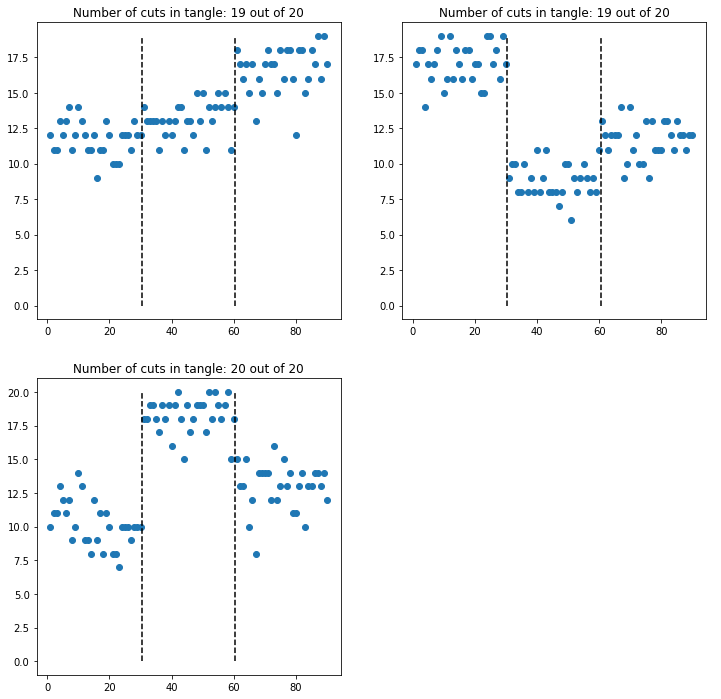

In [17]:
num_persons = questionnaire.shape[0]
k = len(clusters)
dim_plot = np.int(np.ceil(np.sqrt(k)))

f, axs = plt.subplots(nrows=dim_plot, ncols = dim_plot, figsize=(12,12))
if k==1:
    axs = np.array(axs)
axs = axs.flatten()
for i, cluster in enumerate(clusters):
    axs[i].scatter(np.arange(1, num_persons+1), cluster)
    for j in range(1, num_templates):
        axs[i].vlines(x=j * persons_per_template + 0.5, ymin=0, ymax=max(cluster), linestyles='dashed')   
    axs[i].set_title(f'Number of cuts in tangle: {num_cuts[i]} out of {num_questions}')
for i in range(k, len(axs)):
    axs[i].axis('off')

Interpetation: if $n$ is chosen large enough, only the high-level structure is revealed, that is, the templates are recovered

#### Compare tangles as "typical ways of answering" with templates

In [18]:
tangles_on_templates(templates, tangles.maximal_tangles)

array([1., 0., 0.])

Interpretation: Every template (columns) can be described by a tangle (rows)